### 1.1.1 Parallel Data Resampling and Randomness Verification

This notebook demonstrates how to perform data resampling on large datasets 
using parallel processing with Python's `multiprocessing` library. The workflow includes:

- **Data Resampling**: Generates multiple resampled datasets based on different parameters.
- **Data Saving**: Efficiently saves the resampled data in compressed `.npz` files.
- **Randomness Verification**: Ensures the randomness of the sampling process by computing and comparing MD5 hashes of the output files.

By leveraging parallel processing, the resampling process is optimized for performance, making it suitable for handling large-scale data efficiently.


In [ ]:
import numpy as np
import os
from tqdm import tqdm
import pandas as pd
from multiprocessing import Pool
import hashlib

def resample_data(args):
    """
    Resamples and saves data based on the given arguments.

    Parameters:
    - args: A tuple of arguments (rpt, N_resample, matching_keys, xyzdml_data, targets_data, N_case)
    """
    rpt, N_resample, matching_keys, xyzdml_data, targets_data, N_case = args
    input_data = np.zeros([N_case, N_resample, 9])  # input_data has 9 columns
    output_data = np.zeros([N_case, N_resample, 4])  # output_data has 4 columns
    names = []

    # Set a unique seed for each rpt (e.g., based on rpt number)
    seed = 42 + rpt  # Generate a unique seed by adding rpt to the base seed
    np.random.seed(seed)

    for k, name in enumerate(matching_keys):
        print(f"Rpt{rpt} - Processing {name} with index {k}")
        names.append(name)
        my_xyzdml = xyzdml_data[name]
        my_targets = targets_data[name]

        npt = len(my_xyzdml)
        print(f"Rpt{rpt} - npt: {npt}, N_resample: {N_resample}")

        # Generate sampling indices
        if npt <= N_resample:
            index = np.random.choice(npt, N_resample, replace=True)
        else:
            index = np.random.choice(npt, N_resample, replace=False)

        input_data[k, :, :] = my_xyzdml[index, :].copy()
        output_data[k, :, :] = my_targets[index, :].copy()

    names = np.array(names)
    np.savez_compressed(f'../data/sampled/Rpt{rpt}_N{N_resample}.npz', a=input_data, b=output_data, c=names)

def compute_hash(data):
    """
    Computes the MD5 hash of the given data.

    Parameters:
    - data: The data to hash (numpy array)

    Returns:
    - Hash string
    """
    return hashlib.md5(data.tobytes()).hexdigest()

def check_sampling_randomness(base_sampled='../data/sampled/', rpt_values=[0,1,2], N_resample_list=[500, 1000, 2000, 5000, 10000]):
    """
    Checks whether the generated files are created differently for each rpt and N_resample.

    Parameters:
    - base_sampled: Base directory where sampled data is stored
    - rpt_values: List of rpt values to check
    - N_resample_list: List of N_resample values to check
    """
    hashes = {}

    for rpt in rpt_values:
        for N_resample in N_resample_list:
            filepath = os.path.join(base_sampled, f'Rpt{rpt}_N{N_resample}.npz')
            if not os.path.exists(filepath):
                print(f"File does not exist: {filepath}")
                continue
            data = np.load(filepath)
            output_data = data['b']
            data_hash = compute_hash(output_data)
            hashes[(rpt, N_resample)] = data_hash
            print(f"Hash computed - Rpt{rpt}, N_resample={N_resample}: {data_hash}")

    # Compare hashes for each rpt and N_resample
    print("\nStarting sampling results comparison:")
    for N_resample in N_resample_list:
        hashes_per_N = [hashes.get((rpt, N_resample)) for rpt in rpt_values]
        unique_hashes = set(hashes_per_N)
        if len(unique_hashes) == len(rpt_values):
            print(f"N_resample={N_resample}: Sampling was done differently for all rpt values.")
        else:
            print(f"N_resample={N_resample}: Sampling was identical for some rpt values.")
    
    print("Sampling randomness verification completed.")

def main(cpu_count=4):
    """
    Main function that loads data, performs resampling, and validates randomness.

    Parameters:
    - cpu_count: Number of CPU cores to use
    """
    base_npy = '../data/npy/'
    base_sampled = '../data/sampled/'

    filename_xyzdmlc = 'xyzdmlc.npz'
    filename_targets = 'targets.npz'

    os.makedirs(base_sampled, exist_ok=True)

    # Load data
    xyzdml = np.load(os.path.join(base_npy, filename_xyzdmlc))
    targets = np.load(os.path.join(base_npy, filename_targets))

    # Get keys from targets and xyzdml
    xyzdml_keys = set(xyzdml.keys())
    targets_keys = set(targets.keys())

    print(f"Number of xyzdml keys: {len(xyzdml_keys)}")
    print(f"Number of targets keys: {len(targets_keys)}")

    # Find matching keys
    matching_keys = list(targets_keys.intersection(xyzdml_keys))

    # Print results
    print(f"Number of matching keys: {len(matching_keys)}")

    N_case = len(matching_keys)

    # Pre-load data into memory
    targets_data = {name: targets[name] for name in targets.files if name in matching_keys}
    xyzdml_data = {name: xyzdml[name] for name in xyzdml.files if name in matching_keys}

    # Create task list
    tasks = [(rpt, N_resample, matching_keys, xyzdml_data, targets_data, N_case)
            #  for rpt in range(3) # Modify repeat number 
             for rpt in range(1) # Modify repeat number 
             for N_resample in [500, 1000, 2000, 5000, 10000]]  # Modify N_resample list

    # Display progress
    print("Starting resampling process...")
    with Pool(processes=cpu_count) as pool:  # Added cpu_count argument to Pool
        for _ in tqdm(pool.imap_unordered(resample_data, tasks), total=len(tasks)):
            pass  # Display progress with tqdm

    # Verify sampling randomness
    # check_sampling_randomness(base_sampled=base_sampled, rpt_values=[0,1,2], N_resample_list=[500, 1000, 2000, 5000, 10000])
    check_sampling_randomness(base_sampled=base_sampled, rpt_values=[0], N_resample_list=[500, 1000, 2000, 5000, 10000])

if __name__ == '__main__':
    main(cpu_count=16)


Number of xyzdml keys: 6315
Number of targets keys: 6315
Number of matching keys: 6315
Starting resampling process...


  0%|          | 0/5 [00:00<?, ?it/s]IOStream.flush timed out


Rpt0 - Processing ver_611_513 with index 0
Rpt0 - npt: 178276, N_resample: 500
Rpt0 - Processing dia_630_114 with index 1
Rpt0 - npt: 162581, N_resample: 500
Rpt0 - Processing ver_537_321 with index 2
Rpt0 - npt: 220615, N_resample: 500
Rpt0 - Processing ver_285_433 with index 3
Rpt0 - npt: 207414, N_resample: 500
Rpt0 - Processing hor_494_220 with index 4
Rpt0 - npt: 266983, N_resample: 500
Rpt0 - Processing hor_30_489 with index 5
Rpt0 - npt: 143356, N_resample: 500
Rpt0 - Processing hor_371_482 with index 6
Rpt0 - npt: 208505, N_resample: 500
Rpt0 - Processing dia_371_9 with index 7
Rpt0 - npt: 184132, N_resample: 500
Rpt0 - Processing dia_499_422 with index 8
Rpt0 - npt: 199875, N_resample: 500
Rpt0 - Processing dia_519_321 with index 9
Rpt0 - npt: 205370, N_resample: 500
Rpt0 - Processing dia_152_533 with index 10
Rpt0 - npt: 207819, N_resample: 500
Rpt0 - Processing hor_361_456 with index 11
Rpt0 - npt: 171388, N_resample: 500
Rpt0 - Processing dia_194_16 with index 12
Rpt0 - npt

### 1.1.2 Data Visualization

In this section, we visualize the resampled data by generating histograms for various stress components across different sampling parameters. The workflow includes:

- **Data Loading and Clipping**: Loads the resampled datasets, applies clipping to stress values to focus on a specific range, and organizes the data based on direction and stress type.
- **Histogram Plotting**: Creates and saves histograms for each stress component (`ux`, `uy`, `uz`, and von Mises stress) across vertical, horizontal, and diagonal directions. This helps in understanding the distribution and variability of the stress values under different sampling scenarios.

By implementing these visualization steps, we gain insights into the behavior of stress measurements, ensuring that the resampling process maintains the integrity and variability of the original data.


Starting visualization for ver_stress(MPa), hor_stress(MPa), dia_stress(MPa)...


  0%|          | 0/5 [00:00<?, ?it/s]

VER N=500, Clipping ux values to range: [-0.15146854150295258, 1.2512194429638333]
VER N=500, Clipping uy values to range: [-0.2028870406448841, 0.1684320752918848]
VER N=500, Clipping uz values to range: [-0.07288903617858887, 2.3063587808609345]
VER N=500, Clipping von Mises stress values to range: [0, 263.847458007815]
HOR N=500, Clipping ux values to range: [-0.8571251280903817, 0.036642064079652786]
HOR N=500, Clipping uy values to range: [-0.052076520912349225, 0.058686037361628085]
HOR N=500, Clipping uz values to range: [-0.7508258195519447, 0.223218013420703]
HOR N=500, Clipping von Mises stress values to range: [0, 258.4129714965833]


 20%|██        | 1/5 [00:00<00:03,  1.28it/s]

DIA N=500, Clipping ux values to range: [-0.1270235081911087, 0.04470900087431106]
DIA N=500, Clipping uy values to range: [-0.12293050166219473, 0.12342950256168891]
DIA N=500, Clipping uz values to range: [-0.013593999668955803, 0.2798345218896887]
DIA N=500, Clipping von Mises stress values to range: [0, 241.36744079590244]
VER N=1000, Clipping ux values to range: [-0.15180599889159202, 1.25481909251214]
VER N=1000, Clipping uy values to range: [-0.20271900495886802, 0.16878107839824097]
VER N=1000, Clipping uz values to range: [-0.07375601388514041, 2.2909579739572257]
VER N=1000, Clipping von Mises stress values to range: [0, 263.9966142578128]
HOR N=1000, Clipping ux values to range: [-0.8587221555113792, 0.03619800435379197]
HOR N=1000, Clipping uy values to range: [-0.0519170186035335, 0.05882600249722649]
HOR N=1000, Clipping uz values to range: [-0.7474001348018646, 0.2227299988567834]
HOR N=1000, Clipping von Mises stress values to range: [0, 257.9930756225591]


 40%|████      | 2/5 [00:02<00:03,  1.28s/it]

DIA N=1000, Clipping ux values to range: [-0.1264640043824911, 0.04493800377845797]
DIA N=1000, Clipping uy values to range: [-0.12394601461291313, 0.12356603465229814]
DIA N=1000, Clipping uz values to range: [-0.013674000278115273, 0.27993008452655344]
DIA N=1000, Clipping von Mises stress values to range: [0, 241.39912815857]
VER N=2000, Clipping ux values to range: [-0.15227000814676284, 1.261129996299747]
VER N=2000, Clipping uy values to range: [-0.2027670025974512, 0.16773300072550806]
VER N=2000, Clipping uz values to range: [-0.07384000173211097, 2.29002412605287]
VER N=2000, Clipping von Mises stress values to range: [0, 263.82819003295964]
HOR N=2000, Clipping ux values to range: [-0.860175326526165, 0.036357004471123874]
HOR N=2000, Clipping uy values to range: [-0.05211801164224744, 0.05882600249722649]
HOR N=2000, Clipping uz values to range: [-0.7442970915436745, 0.22369200791418684]
HOR N=2000, Clipping von Mises stress values to range: [0, 258.1902503051764]
DIA N=2000

 60%|██████    | 3/5 [00:05<00:04,  2.18s/it]

DIA N=2000, Clipping uz values to range: [-0.01359900094009936, 0.27940300607681356]
DIA N=2000, Clipping von Mises stress values to range: [0, 241.48842533874623]
VER N=5000, Clipping ux values to range: [-0.15194599431753159, 1.2569710645676935]
VER N=5000, Clipping uy values to range: [-0.20352600514888763, 0.16816499829292297]
VER N=5000, Clipping uz values to range: [-0.0742320061326027, 2.2851901063919087]
VER N=5000, Clipping von Mises stress values to range: [0, 263.9591676025393]
HOR N=5000, Clipping ux values to range: [-0.8589060070514679, 0.0360430004782995]
HOR N=5000, Clipping uy values to range: [-0.05197900360822678, 0.058562001351271153]
HOR N=5000, Clipping uz values to range: [-0.7479670177698136, 0.22263901846115686]
HOR N=5000, Clipping von Mises stress values to range: [0, 257.9386945495694]
DIA N=5000, Clipping ux values to range: [-0.1273350000679493, 0.04496299948170984]
DIA N=5000, Clipping uy values to range: [-0.12401800058037042, 0.12330300460756027]
DIA N=

 80%|████████  | 4/5 [00:13<00:04,  4.55s/it]

DIA N=5000, Clipping von Mises stress values to range: [0, 241.46325756836086]
VER N=10000, Clipping ux values to range: [-0.1519480069577694, 1.2609620114564937]
VER N=10000, Clipping uy values to range: [-0.2035120010524988, 0.16811500689387726]
VER N=10000, Clipping uz values to range: [-0.07427699963748455, 2.296904100894956]
VER N=10000, Clipping von Mises stress values to range: [0, 264.26318447876156]
HOR N=10000, Clipping ux values to range: [-0.8584540350437164, 0.03596799820661545]
HOR N=10000, Clipping uy values to range: [-0.05207900058105588, 0.05832300162688303]
HOR N=10000, Clipping uz values to range: [-0.7456799815893174, 0.2225829978883307]
HOR N=10000, Clipping von Mises stress values to range: [0, 257.6919267272983]
DIA N=10000, Clipping ux values to range: [-0.1273179968446493, 0.04488300159573555]
DIA N=10000, Clipping uy values to range: [-0.12401800058037042, 0.12318500131368637]
DIA N=10000, Clipping uz values to range: [-0.013620001331903041, 0.279662996530532

100%|██████████| 5/5 [00:30<00:00,  6.03s/it]

DIA N=10000, Clipping von Mises stress values to range: [0, 241.4698185119637]
Visualizing and Saving ver Data for ux After Clipping...


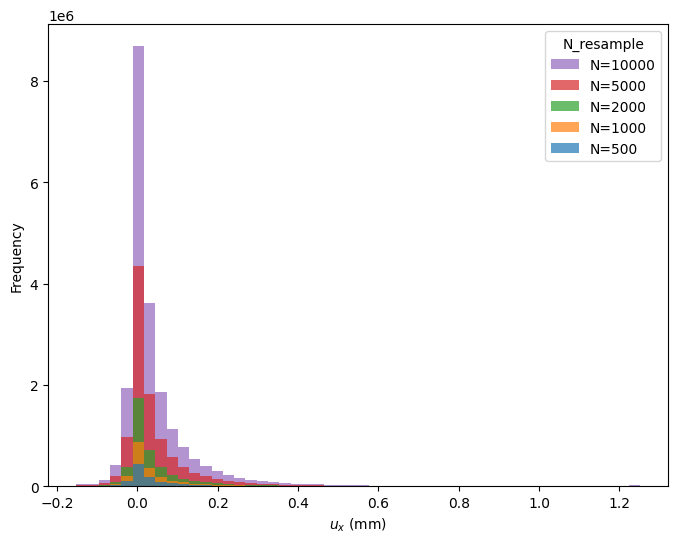

Visualizing and Saving hor Data for ux After Clipping...


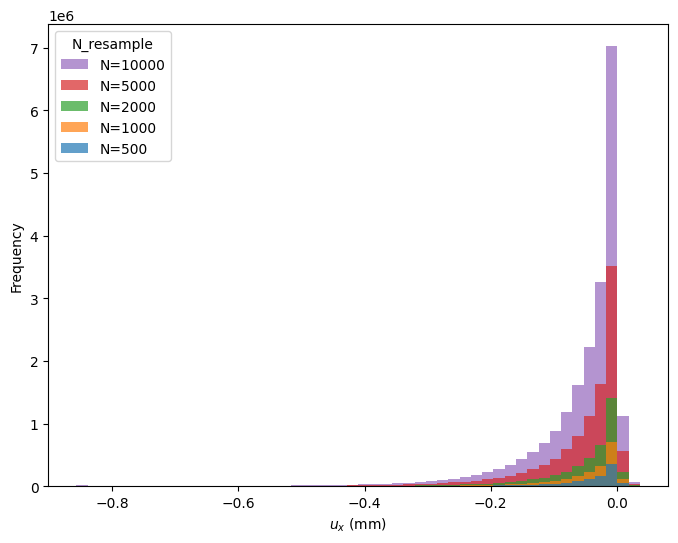

Visualizing and Saving dia Data for ux After Clipping...


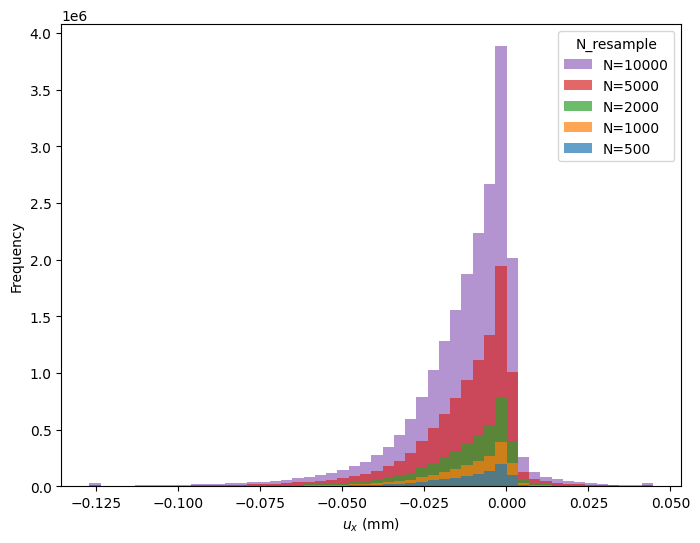

Visualizing and Saving ver Data for uy After Clipping...


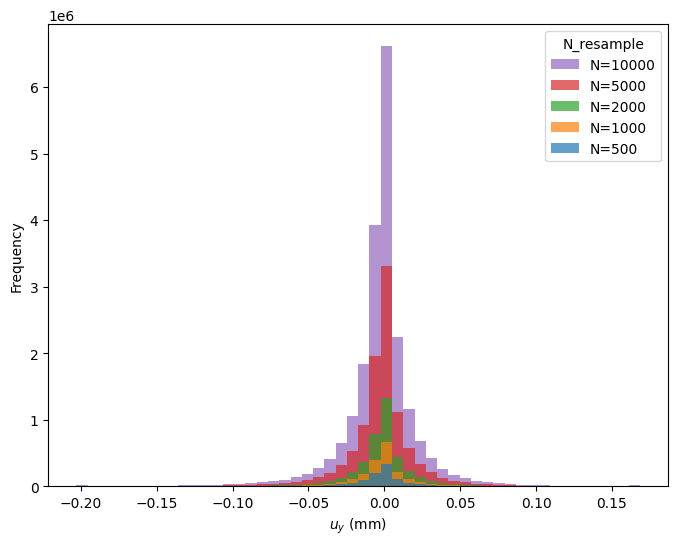

Visualizing and Saving hor Data for uy After Clipping...


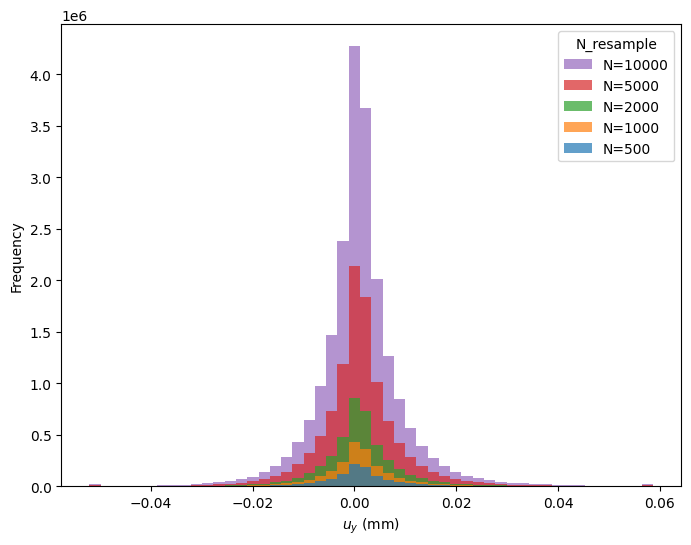

Visualizing and Saving dia Data for uy After Clipping...


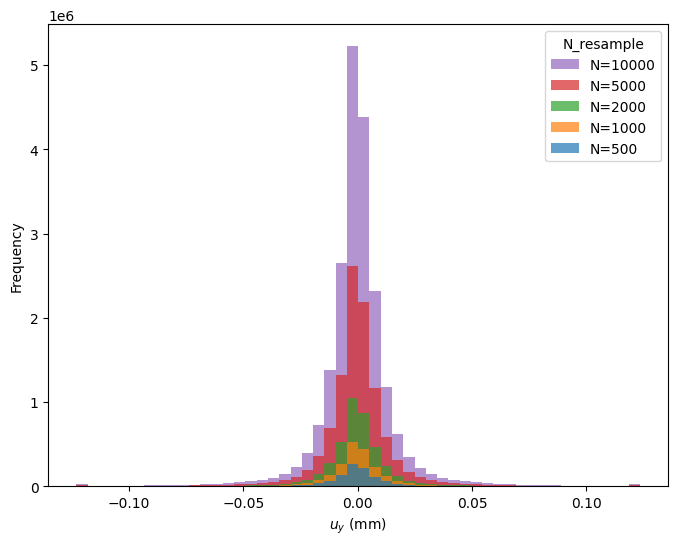

Visualizing and Saving ver Data for uz After Clipping...


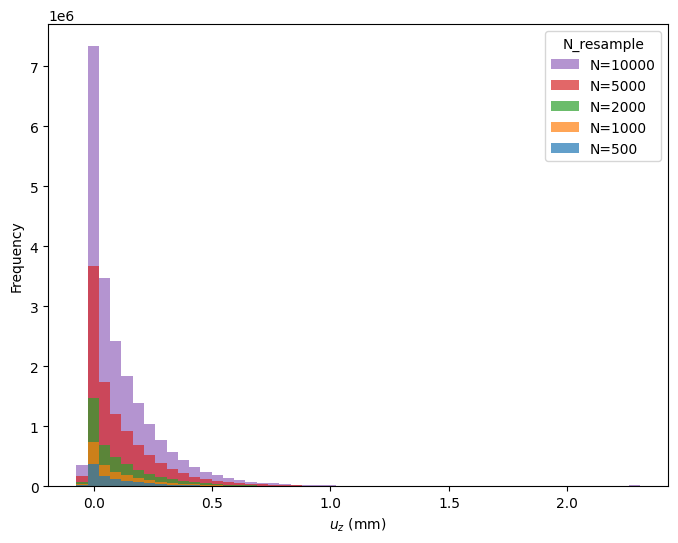

Visualizing and Saving hor Data for uz After Clipping...


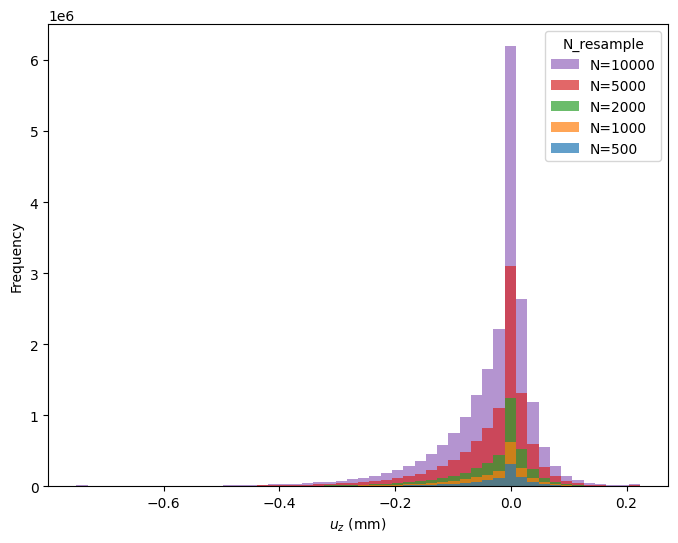

Visualizing and Saving dia Data for uz After Clipping...


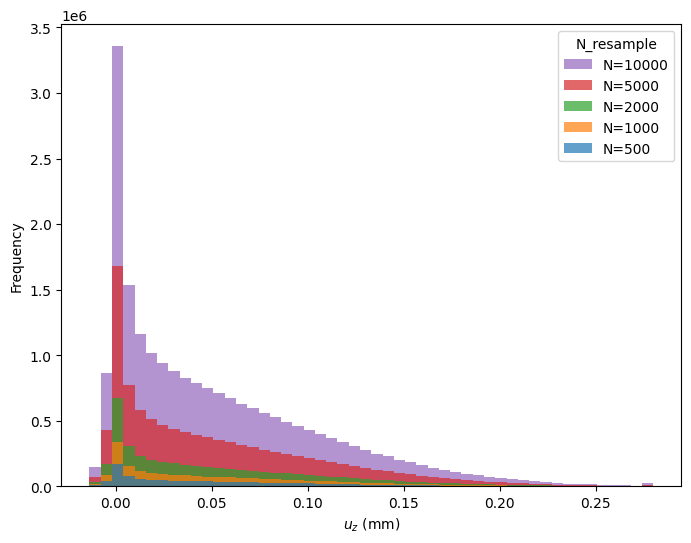

Visualizing and Saving ver Data for von Mises stress After Clipping...


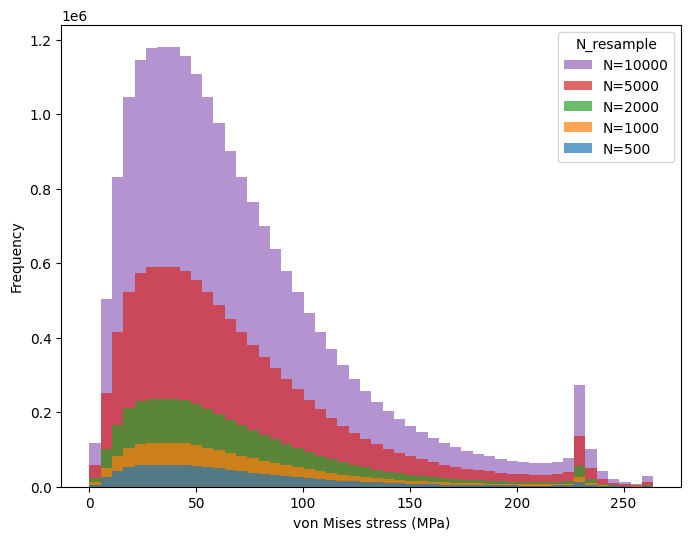

Visualizing and Saving hor Data for von Mises stress After Clipping...


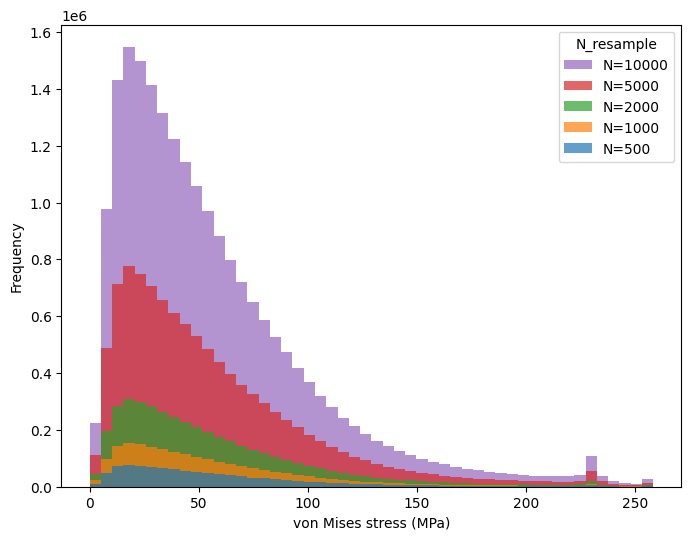

Visualizing and Saving dia Data for von Mises stress After Clipping...


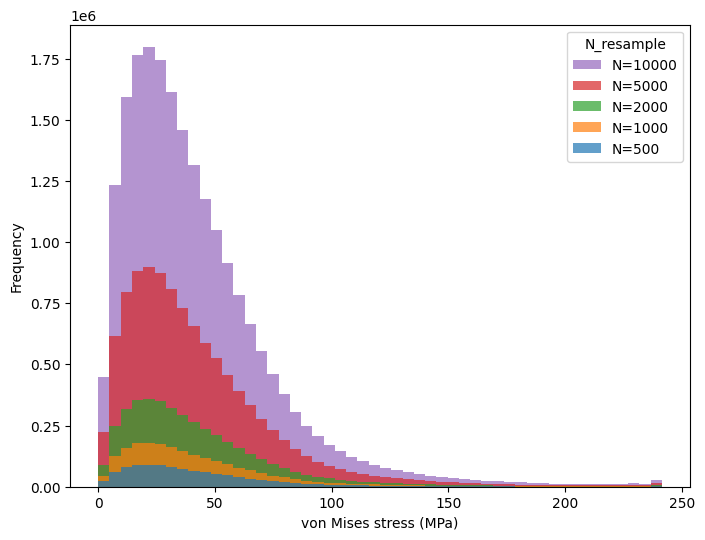

Visualization and saving completed.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os


# Mapping for label names and their descriptive forms
label_names = ['ux', 'uy', 'uz', 'von Mises stress']
label_descriptions = {
    'ux': '$u_x$ (mm)',
    'uy': '$u_y$ (mm)',
    'uz': '$u_z$ (mm)',
    'von Mises stress': 'von Mises stress (MPa)'
}

# Mapping for direction abbreviations to full forms
direction_full = {
    'ver': 'vertical',
    'hor': 'horizontal',
    'dia': 'diagonal'
}

base_figures = '../figures/'

def clip_stress_values(data, min_val, max_val):
    """
    Clips stress values to a specified range.

    Parameters:
    - data: Numpy array of stress values.
    - min_val: Minimum value for clipping.
    - max_val: Maximum value for clipping.

    Returns:
    - Clipped numpy array.
    """
    return np.clip(data, min_val, max_val)

def plot_hist_stress(data_dict, N_resample, direction, min_clip, max_clip, label_name, target_index, base_figures):
    """
    Plots and saves histograms of stress values after clipping.

    Parameters:
    - data_dict: Dictionary containing stress data for different N_resample values.
    - N_resample: List of resample sizes.
    - direction: Direction of stress ('ver', 'hor', 'dia').
    - min_clip: Minimum clipping value.
    - max_clip: Maximum clipping value.
    - label_name: Name of the stress component.
    - target_index: Index of the stress component.
    - base_figures: Base directory to save figures.
    """
    # Get the full form of the direction
    direction_full_name = direction_full.get(direction, direction)
    
    # Get the descriptive label name
    label_description = label_descriptions.get(label_name, label_name)
    
    # Color palette
    colors = plt.get_cmap('tab10').colors

    # Create the plot
    plt.figure(figsize=(8, 6))
    for idx, n in reversed(list(enumerate(N_resample))):
        # Apply clipping
        if target_index == 3:  # For 'von Mises stress', set min_clip to 0
            clipped_data = clip_stress_values(data_dict[n], 0, max_clip)
        else:
            clipped_data = clip_stress_values(data_dict[n], min_clip, max_clip)
        
        # Plot histogram
        plt.hist(
            clipped_data, bins=50, color=colors[idx % len(colors)], 
            label=f'N={n}', alpha=0.7
        )
    
    # Set the title and labels
    plt.xlabel(label_description)  # Changed: set fontsize to 20
    plt.ylabel('Frequency')
    plt.legend(title='N_resample')

    # Save the image
    save_path = os.path.join(base_figures, f'{direction}_{label_name}.png')
    plt.savefig(save_path)
    plt.show()
    plt.close()

# Information about the files to load
base_path = '../data/sampled/'
rpt = 0
N_resample_values = [500, 1000, 2000, 5000, 10000]
base_figures = '../figures/sampling/'

# Create the image save directory if it doesn't exist
if not os.path.exists(base_figures):
    os.makedirs(base_figures)

print("Starting visualization for ver_stress(MPa), hor_stress(MPa), dia_stress(MPa)...")

# Initialize data storage by direction and target_index
data_dicts = {
    'ver': {i: {} for i in range(4)}, 
    'hor': {i: {} for i in range(4)}, 
    'dia': {i: {} for i in range(4)}
}
min_clip_dict = {i: {} for i in range(4)}
max_clip_dict = {i: {} for i in range(4)}

# Load data for each N_resample value
for N_resample in tqdm(N_resample_values):
    file_path = f'{base_path}Rpt{rpt}_N{N_resample}.npz'
    if not os.path.exists(file_path):
        print(f"File {file_path} does not exist. Skipping...")
        continue

    data = np.load(file_path)
    
    # Get the list of keys (e.g., ['ver_101_1', 'hor_101_1', 'dia_101_1'])
    keys = data['c']
    stress_data = data['b']  # 'b' represents stress data

    for direction in ['ver', 'hor', 'dia']:
        # Find indices of keys that start with the current direction
        direction_indices = [i for i, key in enumerate(keys) if key.startswith(f'{direction}_')]
        if not direction_indices:
            print(f"No data available for direction {direction} with N={N_resample}")
            continue
        
        # Extract and store stress data for each target_index
        for target_index in range(4):
            label_name = label_names[target_index]
            # Extract relevant stress data and flatten
            direction_stress_data = stress_data[direction_indices, :, target_index].reshape((-1,))
            data_dicts[direction][target_index][N_resample] = direction_stress_data

            # Calculate clipping range
            min_clip = np.percentile(direction_stress_data, 0.1)
            max_clip = np.percentile(direction_stress_data, 99.9)
            
            # For 'von Mises stress', set min_clip to 0
            if target_index == 3:
                min_clip = 0
            
            print(f'{direction.upper()} N={N_resample}, Clipping {label_name} values to range: [{min_clip}, {max_clip}]')

            # Save clipping ranges based on the first N_resample value
            if N_resample == N_resample_values[0]:
                min_clip_dict[target_index][direction] = min_clip
                max_clip_dict[target_index][direction] = max_clip

# Perform visualization for each direction and label after clipping
for target_index in range(4):
    label_name = label_names[target_index]
    for direction in ['ver', 'hor', 'dia']:
        # Check if data exists for the current direction and label
        if direction not in data_dicts or target_index not in data_dicts[direction]:
            print(f"No data to visualize for direction {direction} and label {label_name}")
            continue

        print(f"Visualizing and Saving {direction} Data for {label_name} After Clipping...")
        plot_hist_stress(
            data_dicts[direction][target_index], 
            N_resample_values, 
            direction, 
            min_clip_dict[target_index].get(direction, None), 
            max_clip_dict[target_index].get(direction, None), 
            label_name, 
            target_index, 
            base_figures
        )

print("Visualization and saving completed.")
